# Meyer-Wallach Measure and Entangling Capability

This Jupyter notebook was created by [Umberto Borso](https://www.linkedin.com/in/umberto-borso-1990a11a1/) and is part of the Semester Project titled *"Quantum Advantage in Machine Learning: Investigating Entanglement and Quantum Feature Maps in Neural Networks"*. This nootebook contains part of the code used to analyze how the design choices of different Quantum feature maps and Variational Circuits affect the performance of a Quantum Neural Network in terms of Entangling Capability. 

## Assessing Entanglement in Quantum Neural Networks (QNNs)

This code segment focuses on examining the impact of entanglement on QNNs using the Meyer-Wallach measure. This measure evaluates the entangling capabilities of feature maps and variational circuits, correlating them with performance metrics like effective dimension and Fisher information spectrum.

**Approach**:
1. **Monte Carlo Sampling**: Random input samples $\boldsymbol{x}_i$ and parameter samples $\boldsymbol{\theta}_i$ are generated (5000 sets) to estimate the entangling capabilities over the entire parameter space.

2. **Initial States and Circuits**: Feature maps initilized in the zero basis state $\ket{0}^{\otimes N}$, while three different initilization scenarios for variational circuits are considered:
    - Initialized in the zero basis state $\ket{0}^{\otimes N}$.
    - Input states generated from feature map FM5.
    - Input states generated from feature map FM3 (aligning with trainability and capacity analyses in the QNN models).

#
3. **Entanglement Measurement**: The entanglement of output states is assessed using the Meyer-Wallach measure, averaged over inputs and parameter sets. This results in entangling capability scores for feature maps ($EC_{\mathcal{F}}$) and variational circuits ($EC_{\mathcal{V}}$).

In [4]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit.library import RealAmplitudes, ExcitationPreserving, PauliFeatureMap,EfficientSU2, PauliTwoDesign
import numpy as np
import qutip

## Define functions

- `assign_circuit_params(circuit_obj, params)`: Assigns specified parameters to a given circuit object.

- `compute_Q_ptrace(ket, N)`: Computes the Meyer-Wallach measure as an average over the entanglements of each qubit with the rest of the system.

- `EC_with_FM(circuit_function, circuit_obj, feat_map_object, num_qubits, size, sample=1024)`: Calculates the entangling capability for a circuit after applying a specified feature map, averaging over Meyer-Wallach measure estimates.

- `entangling_capability(circuit_function, circuit_obj, num_qubits, size, sample=1024)`: Returns the entangling capability for a given circuit by averaging multiple Meyer-Wallach measure estimates.

In [245]:
def assign_circuit_params(circuit_obj,params):
    """
        Assignes the specified parameters to the given circuit object 
    """
    quantum_circ = circuit_obj
    parameters = {}
    for i, p in enumerate(quantum_circ.ordered_parameters):
        parameters[p] = params[i]

    circ = quantum_circ.assign_parameters(parameters)
    return circ

In [96]:
def compute_Q_ptrace(ket, N):
    """Computes Meyer-Wallach measure using alternative interpretation, i.e. as
    an average over the entanglements of each qubit with the rest of the system
    (see https://arxiv.org/pdf/quant-ph/0305094.pdf).
   
    Args:
    =====
    ket : numpy.ndarray or list
        Vector of amplitudes in 2**N dimensions
    N : int
        Number of qubits
​
    Returns:
    ========
    Q : float
        Q value for input ket
    """
    ket = qutip.Qobj(ket, dims=[[2]*(N), [1]*(N)]).unit()
    entanglement_sum = 0
    for k in range(N):
        rho_k_sq = ket.ptrace([k])**2
        entanglement_sum += rho_k_sq.tr()  
   
    Q = 2*(1 - (1/N)*entanglement_sum)
    return Q

In [246]:
def entangling_capability(circuit_function, circuit_obj, num_qubits, size, sample=1024):
    """
        Returns the entangling_capability for the given circuit by averaging over multiple Meyer-Wallach measure esitmates. 
    """

    res = np.zeros(sample, dtype=complex)

    for i in range(sample):
        params = np.random.uniform(-1, 1, 16)
        ansatz = circuit_function(circuit_obj,params)
        result = execute(ansatz, 
                       backend=Aer.get_backend('statevector_simulator')).result()
        U = result.get_statevector(ansatz, decimals=20)
        # print(U)
        sv=np.array([i for i in U])

        res[i]=compute_Q_ptrace(sv,num_qubits)
    
    return np.average(res)

In [ ]:
def EC_with_FM(circuit_function, circuit_obj, feat_map_object, num_qubits, size, sample=1024):
    """
        Returns the entangling_capability for the given circuit, after the specified feature map has been applied,
        by averaging over multiple Meyer-Wallach measure esitmates.
    """

    res = np.zeros(sample, dtype=complex)
    N = num_qubits

    for i in range(sample):
        fm_params = np.random.normal(0, 1, 4)
        feature_map = circuit_function(feat_map_object,fm_params)
        params = np.random.uniform(-1, 1, 20)
        qc=QuantumCircuit(4)
        qc.append(feature_map,range(4))
        ansatz = circuit_function(circuit_obj,params)
        qc.append(ansatz,range(4))

        result = execute(qc, 
                       backend=Aer.get_backend('statevector_simulator')).result()
        U = result.get_statevector(qc, decimals=20)
        sv=np.array([i for i in U])

        res[i]=compute_Q_ptrace(sv,num_qubits)
    
    return np.average(res)

## Evaluate Feature Maps Entangling Capability

In [184]:
FeatureMaps = {
    'FM1': PauliFeatureMap(4, reps=1, paulis=['Z']),
    'FM2': PauliFeatureMap(4, reps=1, paulis=['ZZ']),
    'FM3': PauliFeatureMap(4, reps=1, paulis=['Z','ZZ']),
    'FM4': PauliFeatureMap(4, reps=1, paulis=['Z','XX']),
    'FM5': PauliFeatureMap(4, reps=1, paulis=['Y','ZX']),
    'FM6': PauliFeatureMap(4, reps=1, paulis=['Z','ZZZ']),
    'FM7': PauliFeatureMap(4, reps=1, paulis=['Z','YY','ZZZ']),
}

In [ ]:
mwFeatureMaps = np.zeros(7,dtype=float)
for i,fm in enumerate(FeatureMaps.keys()):
    mw = entangling_capability(assign_circuit_params,FeatureMaps[fm], 4,4)
    mwFeatureMaps[i] = mw

## Evaluate Variational Circuits Entangling Capability

In [210]:
VarCircuits = {
    'VC1': PauliTwoDesign(num_qubits=4, reps=9, seed=None, insert_barriers=False, name='PauliTwoDesign'),
    'VC2': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='circular',skip_final_rotation_layer=True),
    'VC3': ExcitationPreserving(4, reps=4, insert_barriers=True, entanglement='full'),
    'VC4': RealAmplitudes(4, reps=9, insert_barriers=True, entanglement='full'),
    'VC5': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='pairwise',skip_final_rotation_layer=False),
    'VC6': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='linear'),
    'VC7': EfficientSU2(4, su2_gates=['rx', 'y'], entanglement='circular', reps=9),
    'VC8': RealAmplitudes(4, reps=9, insert_barriers=True, entanglement='linear'),
    'VC9': ExcitationPreserving(4, reps=5, insert_barriers=True, entanglement='sca',skip_final_rotation_layer=True)
}

VarCircuits_1rep = {
    'VC1': PauliTwoDesign(num_qubits=4, reps=1, seed=None, insert_barriers=False, name='PauliTwoDesign'),
    'VC2': ExcitationPreserving(4, reps=1, insert_barriers=True, entanglement='circular',skip_final_rotation_layer=True),
    'VC3': ExcitationPreserving(4, reps=1, insert_barriers=True, entanglement='full'),
    'VC4': RealAmplitudes(4, reps=1, insert_barriers=True, entanglement='full'),
    'VC5': ExcitationPreserving(4, reps=1, insert_barriers=True, entanglement='pairwise',skip_final_rotation_layer=False),
    'VC6': ExcitationPreserving(4, reps=1, insert_barriers=True, entanglement='linear'),
    'VC7': EfficientSU2(4, su2_gates=['rx', 'y'], entanglement='circular', reps=1),
    'VC8': RealAmplitudes(4, reps=1, insert_barriers=True, entanglement='linear'),
    'VC9': ExcitationPreserving(4, reps=1, insert_barriers=True, entanglement='sca',skip_final_rotation_layer=True)
}

In [ ]:
mwVC = np.zeros(9,dtype=float)
for i,vc in enumerate(VarCircuits_1rep.keys()):
    mw = entangling_capability(assign_circuit_params,VarCircuits_1rep[vc], 4,4)
    mwVC[i] = mw

In [ ]:
mwVC_FM3 = np.zeros(9,dtype=float)
for i,vc in enumerate(VarCircuits_1rep.keys()):
    mw = EC_with_FM(assign_circuit_params,VarCircuits_1rep[vc], FeatureMaps['FM3'], 4,4)
    mwVC_FM3[i] = mw

In [ ]:
mwVC_FM5 = np.zeros(9,dtype=float)
for i,vc in enumerate(VarCircuits_1rep.keys()):
    mw = EC_with_FM(assign_circuit_params,VarCircuits_1rep[vc], FeatureMaps['FM5'], 4,4)
    mwVC_FM5[i] = mw

## Plotting results

In [3]:
# I personally prefer seaborn for the graph style, but you may choose whichever you want.
plt.style.use('seaborn') 
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

/var/folders/jc/0syfv27n0s37cg9l4jsm306w0000gn/T/ipykernel_30379/1744123026.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


FM7 -2.484991379336776e-16
FM7 0.2891525077014033
FM7 0.3686452785573926
FM7 0.7104858960384586
FM7 0.7481431134410481
FM7 0.8782407840635742
FM7 0.8848880162912042
['-1', 'FM1', 'FM4', 'FM5', 'FM7', 'FM6', 'FM2', 'FM3', '']


/var/folders/jc/0syfv27n0s37cg9l4jsm306w0000gn/T/ipykernel_99613/1355981869.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


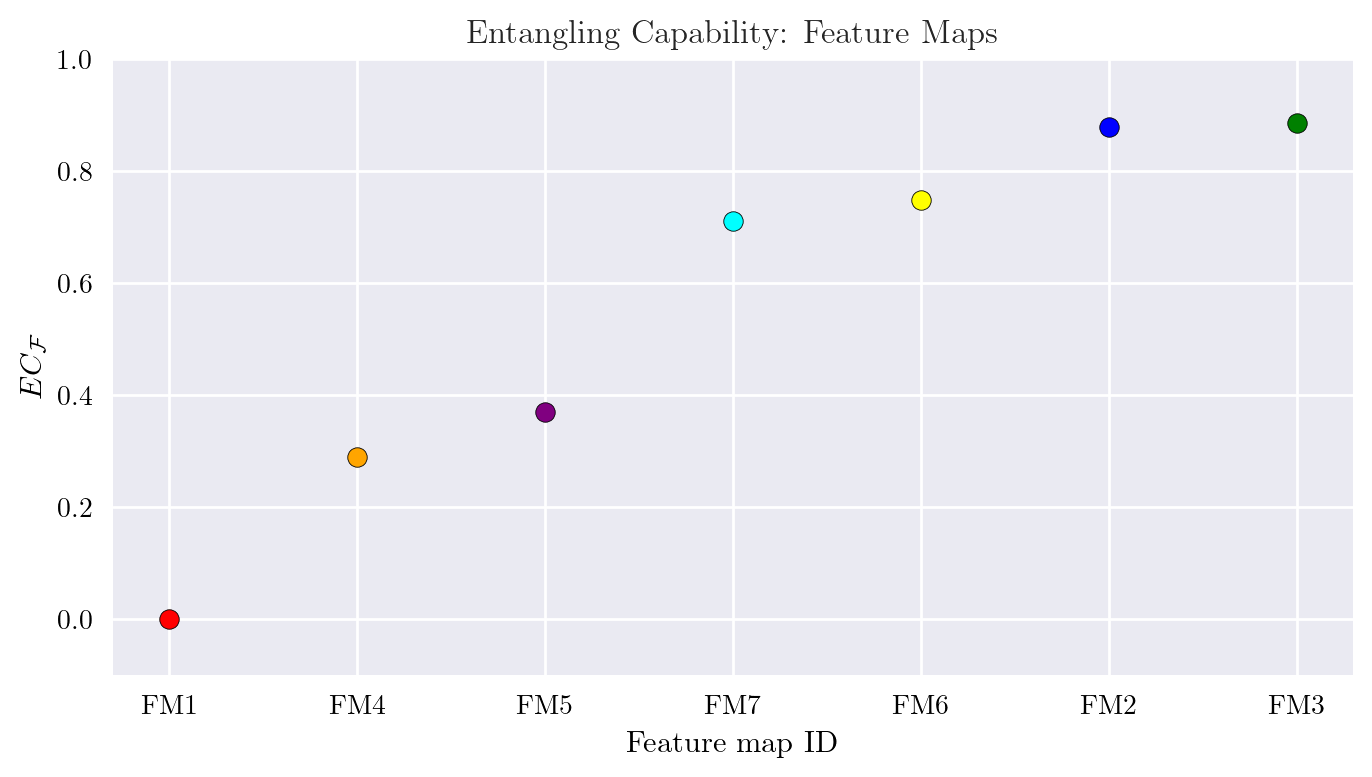

In [350]:
colors_fm = ["red", "blue", "green", "orange", "purple", "yellow", "cyan", "magenta", "lime"]
indeces = np.argsort(mwFeatureMaps)
labels = list(FeatureMaps.keys())

plt.figure(figsize=[8,4],dpi=200)
ax = plt.subplot(111)

plt.title('Entangling Capability: Feature Maps')
for n,i in enumerate(indeces):
    print(fm, mwFeatureMaps[i])
    ax.scatter(n,mwFeatureMaps[i],color=colors_fm[i],edgecolors='black')

ax.set_xlabel("Feature map ID")
ax.set_ylabel("$EC_{\mathcal{F}}$")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [7,4,0,5,1,3,8,6,2]

#add legend to plot
ticks = np.concatenate(([-1],[list(FeatureMaps.keys())[idx] for idx in indeces]))
ax.set_xticklabels(ticks)
print([item.get_text() for item in ax.get_xticklabels()])
ax.set_ylim(-0.1,1)

plt.savefig('../Figures/FM_entanglement.png',dpi=300)
plt.show()

VC9 -2.3332030751888055e-16
VC9 -2.3288662664988635e-16
VC9 -2.3201926491189795e-16
VC9 -2.1597307275911248e-16
VC9 -2.0296264668928643e-16
VC9 0.33023263741285147
VC9 0.3931976293288601
VC9 0.39430549247873103
VC9 0.5917943779903545
['-1', 'VC9', 'VC3', 'VC5', 'VC6', 'VC2', 'VC4', 'VC1', 'VC8', 'VC7', '']


/var/folders/jc/0syfv27n0s37cg9l4jsm306w0000gn/T/ipykernel_99613/1103726719.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


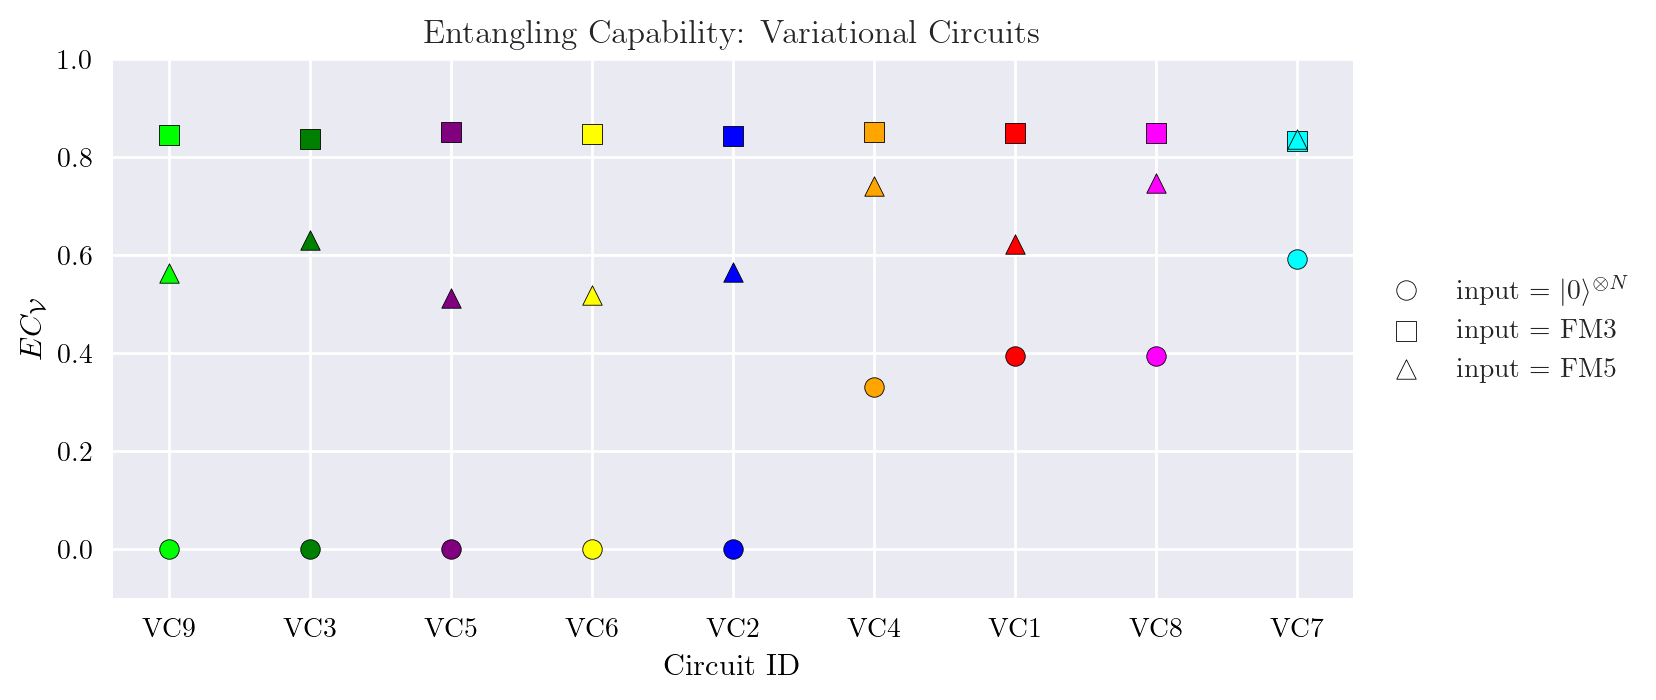

In [383]:
colors_fm = ["red", "blue", "green", "orange", "purple", "yellow", "cyan", "magenta", "lime"]
indeces = np.argsort(mwVC)
labels = list(VarCircuits.keys())

plt.figure(figsize=[10,3.5],dpi=200)
ax = plt.subplot(111)

plt.title('Entangling Capability: Variational Circuits')
for n,i in enumerate(indeces):
    print(vc, mwVC[i])
    ax.scatter(n,mwVC[i],color=colors_fm[i],edgecolors='black')
    ax.scatter(n,mwVC_FM3[i],color=colors_fm[i],edgecolors='black',marker=',')
    ax.scatter(n,mwVC_FM5[i],color=colors_fm[i],edgecolors='black',marker='^')

ax.scatter(1,-mwVC_FM3[i],color='white',edgecolors='black',marker='o',label=r'input $=|0 \rangle^{\otimes N}$')
ax.scatter(1,-mwVC_FM3[i],color='white',edgecolors='black',marker=',',label='input $=$ FM3')
ax.scatter(1,-mwVC_FM3[i],color='white',edgecolors='black',marker='^',label='input $=$ FM5')

ax.set_xlabel("Circuit ID")
ax.set_ylabel("$EC_{\mathcal{V}}$")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [7,4,0,5,1,3,8,6,2]

#add legend to plot
ticks = np.concatenate(([-1],[list(VarCircuits.keys())[idx] for idx in indeces]))
ax.set_xticklabels(ticks)
print([item.get_text() for item in ax.get_xticklabels()])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.1,1)

plt.savefig('../Figures/VC_entanglement.png',dpi=300)
plt.show()